In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import multiprocessing as mp
import scipy.stats as stats
from scipy.interpolate import UnivariateSpline
from scipy.optimize import bisect, leastsq

In [3]:
kw = dict(where='Temp < 8.77845 & k != 0 & k != 11111', columns=['M2'])

with pd.get_store('/Users/matt/Dropbox/data/fss/data.h5') as store:
    data = pd.concat([store.select('old/free', **kw)])
                      #store.select('old/free_extra', **kw)])

data.index.names = [s if s != 'Stage' else 'LogSweeps' for s in data.index.names]
#data.sortlevel(inplace=True)

In [4]:
data.head()

M2
L Temp     k     LogSweeps Run          
8 7.750308 21111 4         0    0.000023
                           1    0.000011
                           2    0.000019
                           3    0.000026
                           4    0.000026

In [5]:
chi = data.eval('L**5 * M2')

In [6]:
chi_mean = (chi.groupby(level=['L','Temp','k','LogSweeps'])
               .agg(['mean','sem']))

In [7]:
chi_mean.head()

mean       sem
L Temp     k     LogSweeps                    
8 7.750308 21111 4          0.617912  0.011528
                 5          0.610175  0.007316
                 6          0.618266  0.004772
                 7          0.625839  0.004104
                 8          0.619240  0.002518

In [8]:
chi_final = (chi_mean.groupby(level=['L','Temp','k'])
                     .apply(lambda df: df.sortlevel('LogSweeps').iloc[-1]))

In [9]:
chi_final.head()

mean       sem
L Temp     k                        
8 7.750308 21111  0.622098  0.001437
           22111  0.483464  0.001013
           22211  0.386329  0.000772
  7.775425 21111  0.661134  0.001390
           22111  0.500405  0.001010

(0.1, 20)

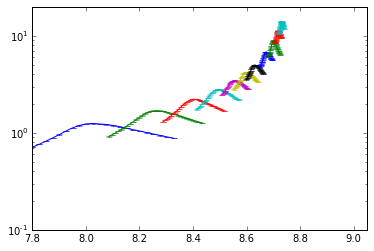

In [10]:
for L, df in chi_final.xs(21111, level='k').groupby(level='L'):
    df.reset_index(inplace=True)
    errorbar(df.Temp, df['mean'], df['sem'])
    
yscale('log')
xlim(7.8, 9.05)
ylim(0.1, 20)

# Wide-range data

In [11]:
from glob import glob

In [12]:
kw = dict(index_col=['bc','d','L','T','k'])
data = pd.concat([pd.read_csv(f, **kw) for f in glob('f-kn-wide/*.csv')])
data = data.reset_index(['bc','d'], drop=True)[['chi','chi_err']]

ValueError: All objects passed were None

In [ ]:
data.head()

In [ ]:
for L, df in data.xs(21111, level='k').groupby(level='L'):
    df.reset_index(inplace=True)
    errorbar(df['T'], df['chi'], df['chi_err'])
    df.to_csv('../../data/chi-f-k21-L{:02d}.csv'.format(L), index=False)
    
yscale('log')
xlim(7.8, 9.05)
ylim(0.1, 20)

# Quotients for $\chi_{21}(T_L)$

In [13]:
chi_final.head()

mean       sem
L Temp     k                        
8 7.750308 21111  0.622098  0.001437
           22111  0.483464  0.001013
           22211  0.386329  0.000772
  7.775425 21111  0.661134  0.001390
           22111  0.500405  0.001010

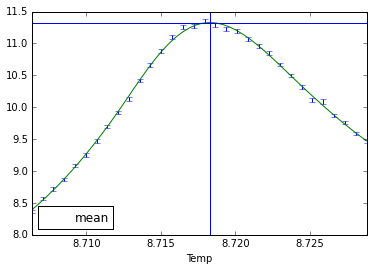

In [14]:
df = chi_mean.xs([32, 21111, 10], level=['L','k','LogSweeps'])
df.plot(y='mean', yerr='sem', ls='')

F = UnivariateSpline(df.index, df['mean'], 1/df['sem'])
x = linspace(*xlim())
plot(x, F(x))

f = F.derivative()
x0 = bisect(f, df.index[0], df.index[-1])
axvline(x0)
axhline(F(x0))

In [15]:
def findTL(y):
    
    try:
        F = UnivariateSpline(y.index, y['mean'], w=1./y['sem'])
        f = F.derivative()
        x0 = bisect(f, y.index[0], y.index[-1])
        y0 = F(x0).item()
        
    except ValueError as e:
        x0 = nan
        y0 = nan
        
    return pd.Series({'TL': x0, 'chiTL': y0})

In [16]:
chiTL = (chi_mean.groupby(level=['L','k','LogSweeps'])
                 .apply(lambda df: findTL(df.reset_index(['L','k','LogSweeps']))))

In [17]:
chiTL.xs(21111, level='k').head()

TL     chiTL
L LogSweeps                    
8 4          8.035640  1.214787
  5          8.041626  1.262076
  6          8.038678  1.246237
  7          8.036738  1.251897
  8          8.029409  1.242032

# Bootstrap

In [18]:
def compute_TL_chi(data):
    
    groupby = ['L','Temp','k','LogSweeps']
    chi_mean = data.groupby(level=groupby).agg(['mean','sem'])
    
    result = (chi_mean.groupby(level=['L','k','LogSweeps'])
                      .apply(lambda df: findTL(df.reset_index(['L','k','LogSweeps']))))
    
    return result

In [19]:
compute_TL_chi(chi).head()

TL     chiTL
L k     LogSweeps                    
8 21111 4          8.035640  1.214787
        5          8.041626  1.262076
        6          8.038678  1.246237
        7          8.036738  1.251897
        8          8.029409  1.242032

In [20]:
def bootstrap_sample(groups):
    return groups.apply(lambda x: x.take(random_integers(0, len(x)-1, len(x))))


class BootstrapSampler:
    
    def __init__(self, data, groupby, reducer):
        self.data = data
        self.groupby = groupby
        self.reducer = reducer
        
    def __call__(self, seed):
        random.seed(seed)
        resamp = bootstrap_sample(self.data.groupby(level=self.groupby, group_keys=False))
        return self.reducer(resamp)

In [21]:
seeds = random_integers(1e5, size=100)
bs = BootstrapSampler(chi, ['L','k','Temp','LogSweeps'], compute_TL_chi)

with mp.Pool(4) as p:
    samples = p.map(bs, seeds)

samples = pd.concat(samples, keys=seeds, names=['seed'])

In [22]:
samples.head()

TL     chiTL
seed L k     LogSweeps                    
2838 8 21111 4          8.013531  1.220342
             5          8.056113  1.286426
             6          8.024242  1.255001
             7          8.035383  1.259982
             8          8.025356  1.243803

In [23]:
samples.to_hdf('chi-k21-TL-samples.h5','samples')

In [24]:
samples = pd.read_hdf('chi-k21-TL-samples.h5','samples')

In [25]:
samples.head()

TL     chiTL
seed L k     LogSweeps                    
2838 8 21111 4          8.013531  1.220342
             5          8.056113  1.286426
             6          8.024242  1.255001
             7          8.035383  1.259982
             8          8.025356  1.243803

In [26]:
samples_final = (samples.groupby(level=['seed','L','k'])
                        .apply(lambda df: df.sortlevel('LogSweeps').iloc[-1]))

In [27]:
def quotients(y, s=2):
    
    pairs = [(L, int(round(s*L))) 
             for L in y.index 
             if int(round(s*L)) in y.index]
    
    return {L1: log(y[L2]/y[L1])/log(s) for L1, L2 in pairs}

In [28]:
def get_quotients(y, ss=[1.5, 2]):
    result = pd.concat({s: pd.Series(quotients(y, s), name='Q') for s in ss})
    result.index.names = result.index.names[:-2] + ['s','L']
    return result

In [29]:
chiTL = samples_final.xs(21111, level='k').chiTL

In [30]:
chiTL.head()

seed  L 
1781  8     1.245808
      10    1.694818
      12    2.223809
      14    2.806517
      16    3.454478
Name: chiTL, dtype: float64

In [32]:
get_quotients(chiTL.loc[1781])

s    L 
1.5  8     1.429067
     12    1.584739
     16    1.678668
     24    1.784525
2.0  8     1.471386
     10    1.561769
     12    1.617393
     14    1.671758
     16    1.716443
     18    1.734261
Name: Q, dtype: float64

In [33]:
qchiTL = (chiTL.groupby(level='seed')
               .apply(lambda y: get_quotients(y.reset_index('seed', drop=True))))

In [34]:
qchiTL_mean = qchiTL.groupby(level=['s','L']).agg(['mean','std'])

In [35]:
qchiTL_mean

mean       std
s   L                     
1.5 8   1.423570  0.004432
    12  1.582374  0.005154
    16  1.677388  0.005471
    24  1.778143  0.005992
2.0 8   1.475225  0.002898
    10  1.561070  0.003172
    12  1.623653  0.003286
    14  1.674810  0.003621
    16  1.710756  0.003014
    18  1.738268  0.003596

In [36]:
qchiTL_cov = qchiTL.unstack(['s','L']).cov()

In [37]:
def hypothesis(X, th):
    z, w = th[:2] # exponents
    C = th[2:] # coefficients
    return array([z + C[i]/L**w for i, (_, L) in zip(X.labels[0], X.values)])

def hyp_fix_omega(w):
    def _hypothesis(X, th):
        z, C = th[0], th[1:]
        return array([z + C[i]/L**w for i, (_, L) in zip(X.labels[0], X.values)])
    return _hypothesis

def hyp_fix_omega_quad(w):
    def _hypothesis(X, th):
        z, C, D = th[0], th[1::2], th[2::2]
        return array([z + C[i]/L**w + D[i]/L**(2*w) 
                      for i, (_, L) in zip(X.labels[0], X.values)])
    return _hypothesis

In [38]:
def sqresids(hypothesis):
    def _sqresids(th, X, y, W):
        """W is the inverse of the covariance matrix y y^T"""
        h = hypothesis(X, th)
        d = h - y
        return d*dot(W, d)
    return _sqresids

In [39]:
min_size_fit = 8
ifit = (qchiTL_mean.index.get_level_values('L') >= min_size_fit)

X = qchiTL_mean.index[ifit]
y = qchiTL_mean['mean'].iloc[ifit]
W = pinv(qchiTL_cov.iloc[ifit, ifit])
#W = diag(1/qchiTc_mean['sem']**2) # neglect correlations
resids2 = sqresids(hyp_fix_omega_quad(1))

th, cov = leastsq(resids2, x0=[2,1,1,1,1], 
                  args=(X, y, W),
                  full_output=True)[:2]

therr = sqrt(diag(cov))
chi2 = sum(resids2(th, X, y, W))
ndf = len(y) - len(th)
Q = 1 - stats.chi2.cdf(chi2, ndf)

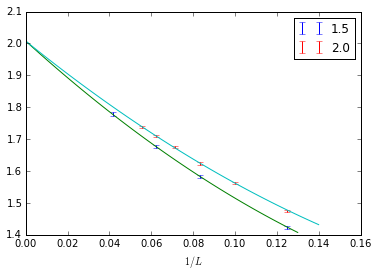

In [40]:
z = th[0]
C = th[1::2]
D = th[2::2]
w = 1

for (s, df), c, d in zip(qchiTL_mean.groupby(level='s'), C, D):
    df.reset_index(inplace=True)
    errorbar(1/df['L'], df['mean'], df['std'], 
             label='{}'.format(s), ls='')
    x = linspace(0, xlim()[1])
    plot(x, z + c*x**w + d*x**(2*w))
    
    df.to_csv('../../data/qchiTL-k21-s{:02d}.csv'.format(int(10*s)), index=False)

xlabel('$1/L$')
legend()

In [41]:
th

array([  2.00769443,  -5.95560398,  10.28977907,  -5.31187128,   8.56200813])

In [42]:
therr

array([ 0.00996155,  0.29241133,  2.00106194,  0.2536943 ,  1.54623024])

In [43]:
params = pd.Series([th[0], therr[0]] + list(th[1:]),
                   index=['yt','yt_err',
                          'C15','D15',
                          'C20','D20'])
params

yt         2.007694
yt_err     0.009962
C15       -5.955604
D15       10.289779
C20       -5.311871
D20        8.562008
dtype: float64

In [44]:
pd.DataFrame(params).T.to_csv('../../fits/qchiTL-k21.fit.csv', index=False)

# Quotients for $\delta T_{21}$

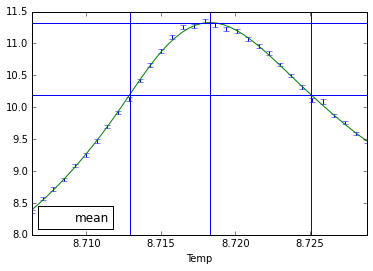

In [45]:
df = chi_mean.xs([32, 21111, 10], level=['L','k','LogSweeps'])
df.plot(y='mean', yerr='sem', ls='')

F = UnivariateSpline(df.index, df['mean'], 1/df['sem'])
x = linspace(*xlim())
plot(x, F(x))

f = F.derivative()
x0 = bisect(f, df.index[0], df.index[-1])
y0 = F(x0)
axvline(x0)
axhline(y0)

yx = 0.9*y0
x1 = bisect(lambda x: F(x) - yx, df.index[0], x0)
x2 = bisect(lambda x: F(x) - yx, x0, df.index[-1])
axhline(yx)
axvline(x1)
axvline(x2)

In [46]:
def find_width(r=0.9):
    def _find_width(y):

        try:
            F = UnivariateSpline(y.index, y['mean'], w=1./y['sem'])
            f = F.derivative()
            TL = bisect(f, y.index[0], y.index[-1])
            y0 = F(TL).item()
            T1 = bisect(lambda T: F(T) - r*y0, y.index[0], TL)
            T2 = bisect(lambda T: F(T) - r*y0, TL, y.index[-1])
            return T2 - T1

        except ValueError as e:
            return nan
        
    return _find_width

In [47]:
find_width_r09 = find_width(0.9)

In [48]:
width = (chi_mean.groupby(level=['L','k','LogSweeps'])
                 .apply(lambda df: find_width_r09(df.reset_index(['L','k','LogSweeps']))))

In [49]:
width.xs(21111, level='k').head()

L  LogSweeps
8  4            0.222416
   5            0.170961
   6            0.196438
   7            0.190513
   8            0.203435
dtype: float64

# Bootstrap

In [51]:
chi.head()

L  Temp      k      LogSweeps  Run
8  7.750308  21111  4          0      0.739071
                               1      0.372932
                               2      0.631427
                               3      0.866564
                               4      0.843267
dtype: float64

In [50]:
def compute_width(data):
    
    groupby = ['L','Temp','k','LogSweeps']
    chi_mean = data.groupby(level=groupby).agg(['mean','sem'])
    
    result = (chi_mean.groupby(level=['L','k','LogSweeps'])
                      .apply(lambda df: find_width_r09(df.reset_index(['L','k','LogSweeps']))))
    
    return result

In [52]:
compute_width(chi).head()

L  k      LogSweeps
8  21111  4            0.222416
          5            0.170961
          6            0.196438
          7            0.190513
          8            0.203435
dtype: float64

In [53]:
seeds = random_integers(1e5, size=100)
bs = BootstrapSampler(chi, ['L','k','Temp','LogSweeps'], compute_width)

with mp.Pool(4) as p:
    samples = p.map(bs, seeds)

samples = pd.concat(samples, keys=seeds, names=['seed'])

In [54]:
samples.to_hdf('chi-k21-width-samples.h5','samples')

In [55]:
samples = pd.read_hdf('chi-k21-width-samples.h5','samples')

In [56]:
samples_final = (samples.groupby(level=['seed','L','k'])
                        .apply(lambda df: df.sortlevel('LogSweeps').iloc[-1])
                        .sortlevel())

In [82]:
samples_final.head()

seed  L   k    
597   8   21111    0.196274
          22111    0.305015
          22211    0.433895
      10  21111    0.127672
          22111    0.197684
dtype: float64

In [98]:
# quotients from old data with wider temperature range
# here r=0.75
samples_final = pd.read_hdf('old/bootstrap-chi-shift-width.h5','resamps').width
samples_final.index.names = ['seed','bc','d','L','k']
samples_final.reset_index(['bc','d'], drop=True, inplace=True)
samples_final.head()

seed  L   k    
0     8   21111    0.136482
          22111    0.245693
          22211         NaN
      10  21111    0.092686
          22111         NaN
Name: width, dtype: float64

In [89]:
chi21width = samples_final.xs(21111, level='k')

In [90]:
chi21width.head()

seed  L 
0     8     0.136482
      10    0.092686
      12    0.066050
      14    0.051443
      16    0.040220
Name: width, dtype: float64

In [92]:
get_quotients(chi21width.loc[0])

s    L 
1.5  8    -1.789991
     12   -1.732547
     16   -1.910055
     24         NaN
2.0  8    -1.762710
     10   -1.780597
     12   -1.832943
     14   -1.856247
     16   -1.907859
     18         NaN
Name: Q, dtype: float64

In [93]:
qchi21width = (chi21width.groupby(level='seed')
                         .apply(lambda y: get_quotients(y.reset_index('seed', drop=True))))

In [94]:
qchi21width_mean = qchi21width.groupby(level=['s','L']).agg(['mean','std'])

In [95]:
qchi21width_cov = qchi21width.unstack(['s','L']).cov()

In [96]:
min_size_fit = 8
ifit = (qchi21width_mean.index.get_level_values('L') >= min_size_fit)

X = qchi21width_mean.index[ifit]
y = qchi21width_mean['mean'].iloc[ifit]
W = pinv(qchi21width_cov.iloc[ifit, ifit])
#W = diag(1/qchiTc_mean['sem']**2) # neglect correlations
resids2 = sqresids(hyp_fix_omega(1))

th, cov = leastsq(resids2, x0=[2,1,1], 
                  args=(X, y, W),
                  full_output=True)[:2]

therr = sqrt(diag(cov))
chi2 = sum(resids2(th, X, y, W))
ndf = len(y) - len(th)
Q = 1 - stats.chi2.cdf(chi2, ndf)

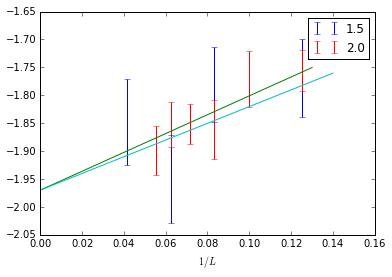

In [108]:
z, C = th[0], th[1:]
w = 1

for (s, df), c in zip(qchi21width_mean.groupby(level='s'), C):
    df.reset_index(inplace=True)
    errorbar(1/df['L'], df['mean'], df['std'], 
             label='{}'.format(s), ls='')
    x = linspace(0, xlim()[1])
    plot(x, z + c*x**w)
    
    df.to_csv('../../data/qwidth-k21-s{:02d}.csv'.format(int(10*s)), index=False)

xlabel('$1/L$')
legend()

In [101]:
th

array([-1.9700668 ,  1.69133504,  1.49868283])

In [102]:
therr

array([ 0.04107361,  0.50917077,  0.44938777])

In [109]:
params = pd.Series([-th[0], therr[0]] + list(th[1:]),
                   index=['yt','yt_err',
                          'C15','C20'])
params

yt        1.970067
yt_err    0.041074
C15       1.691335
C20       1.498683
dtype: float64

In [110]:
pd.DataFrame(params).T.to_csv('../../fits/qwidth-k21.fit.csv', index=False)